In [1]:
from __future__ import division
from aqchem.chemistry import Solute
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance, REqSystem
import periodictable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
substances = Hp, OHm, NH4p, NH3, H2O = [
    Solute(n, formula=periodictable.formula(n)) for n in [
        'H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']]
#substances = substances[::-1]
assert (Hp.charge, OHm.charge, NH4p.charge, NH3.charge, H2O.charge) == (1, -1, 1, 0, 0)
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 1e-7, NH3: 1.0, H2O: 55.5}
x0 = [init_conc[k] for k in substances]
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr
init_conc

{Solute(name=H{+}, ...): 1e-07,
 Solute(name=H2O, ...): 55.5,
 Solute(name=HO{-}, ...): 1e-07,
 Solute(name=NH3, ...): 1.0,
 Solute(name=NH3 + H{+}, ...): 1e-07}

In [3]:
import sympy as sp
sp.init_printing()
ny = len(substances)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
Kw, Ka, sigma = sp.symbols('K_w K_a sigma')
w_autop.params = Kw
NH4p_pr.params = Ka
rs = EqSystem(equilibria, substances)
#f, elim, red_cbs = rs.f(y, i, scaling=sigma, pres1st=True, presw=1000, norm=True, const_indices=(4,))
# y = y[:-1]
ss = sp.symarray('s', ny)
ms = sp.symarray('m', ny)

In [4]:
rs.f_logc(y, i, ln=sp.log, exp=sp.exp)

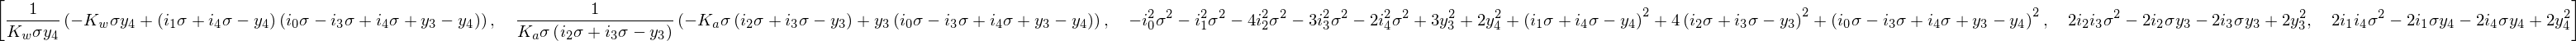

In [4]:
f, elim, red_cbs = rs.f([_*sigma for _ in y], i, scaling=sigma, norm=True, pres_norm=True, rref=False,
                            charge=False, presw=1)
f, elim, red_cbs = rs.f(y, i, scaling=sigma, norm=True,
                            charge=False, presw=1, reduced=True, extra_pres_sq=True)
y = [_ for idx,_ in enumerate(y) if idx not in elim]
#tanh_subs = [(yi, m + s*sp.tanh((yi - m)/s)) for
#             yi, m, s in zip(y, ms, ss)]
#f = [_.subs(tanh_subs) for _ in f]
[_.simplify() for _ in f]
#f

In [7]:
j = sp.Matrix(1, len(f), lambda _, q: f[q]).jacobian(y)
init_conc_j = {Hp: 1e-10, OHm: 1e-7, NH4p: 1e-7, NH3: 1.0, H2O: 55.5}
xj = rs.as_per_substance_array(init_conc_j)
jarr = np.array(j.subs(zip(y, xj)).subs({sigma: 1e0, Kw: 1e-14, Ka: 10**-9.26}).subs(
            zip(i, xj)))
jarr = np.asarray(jarr, dtype=np.float64)
np.log10(np.linalg.cond(jarr))

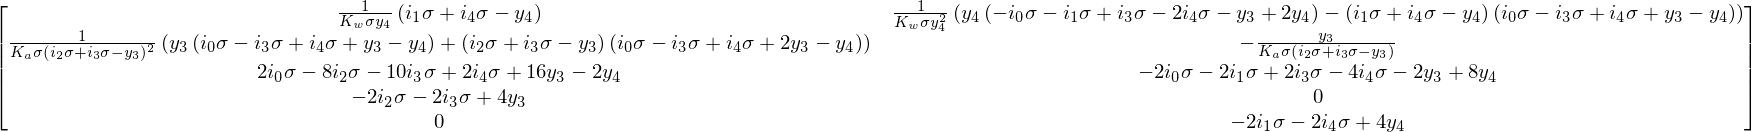

In [8]:
j.simplify()
j

In [9]:
[s.name for s in rs.substances]

['H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']

In [10]:
rs.charge_balance_vector(), rs.atom_balance_vectors()

In [3]:
reqsys = REqSystem(equilibria, substances)
reqsys.root(init_conc, scaling=1e1)

[ 0.  0.]
[ -1.68377257e-07  -1.68377257e-07]
[ -1.92532328e-07  -1.92532328e-07]
[ -1.95824227e-07  -1.95824227e-07]
[ -1.96269712e-07  -1.96269712e-07]
[ -1.96329941e-07  -1.96329941e-07]
[ -1.96338083e-07  -1.96338083e-07]
[ -1.96339184e-07  -1.96339184e-07]
[ -1.96339332e-07  -1.96339332e-07]
[ -1.96339353e-07  -1.96339353e-07]
[ -1.96339355e-07  -1.96339355e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]
[ -1.96339356e-07  -1.96339356e-07]


aqchem/equilibria.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= conc**nr
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(None,
   status: 5
 success: False
     qtf: array([ -1.63691063e-16,   1.80179991e-15])
    nfev: 75
       r: array([ -2.26357425e+05,  -2.26357425e+05,   8.65040818e-17])
     fun: array([ -1.80179991e-15,   1.63691063e-16])
       x: array([  4.21777284e-05,  -4.31777284e-05])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    fjac: array([[ -3.43725049e-13,  -1.00000000e+00],
       [ -1.00000000e+00,   3.43725049e-13]])
    njev: 6)

In [11]:
rs.rref()

In [12]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
for rxn in rs.rxns:
    rxn.params = rxn.params.subs({Kw: 1e-14, Ka: 10**-9.26})

In [13]:
x, res = rs.root(x0, scaling=1, logC=False, square=False)
res.success

True

In [14]:
x, res = rs.root({Hp: 1e-11, OHm: 1e-3, NH4p: 1e-3, NH3: 1.0, H2O: 55.5}, scaling=1, logC=False, square=False)
res.success

True

In [15]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e8, logC=False, square=False)
res.success

True

In [16]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e16, logC=True, square=False)
x

array([  1.7748e-11,   3.0000e-02,   3.0000e-02,   9.7000e-01,   5.5500e+01])

In [17]:
rs.root(x0, scaling=1e8, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([ -2.2150e-10,   2.1725e-23,   1.2001e-19,  -2.7206e-12,   2.1104e-15])
    nfev: 57
       r: array([ -8.1420e+01,   9.7792e-14,   2.0581e-09,   1.2282e-02,  -1.2282e-02,   1.0000e+00,   1.1051e-04,  -2.8704e-13,
         1.0000e+00,  -1.0000e+00,  -1.0000e+00,  -4.4108e-08,  -9.9992e-01,   9.9992e-01,   2.4729e-13])
     fun: array([  5.3638e-19,  -3.7755e-14,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-03,   3.1270e+06,   3.1270e+06,   9.6873e+07,   5.5469e+09])
 message: 'The solution converged.'
    fjac: array([[ -2.6858e-06,  -9.9992e-01,  -1.2282e-02,   9.8086e-14,  -8.4699e-22],
       [  6.1356e-13,   9.8079e-14,   1.2042e-15,   1.0000e+00,   4.9982e-26],
       [  3.7521e-13,   5.4178e-10,  -4.4108e-08,  -3.3875e-23,  -1.0000e+00],
       [ -3.2990e-08,  -1.2282e-02,   9.9992e-01,  -1.2123e-19,  -4.4111e-08],
       [ -1.0000e+

In [18]:
rs.root(x0, scaling=1, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  2.1511e-19,   4.0318e-34,  -1.6481e-29,   6.9426e-21,  -3.8340e-24])
    nfev: 54
       r: array([ -3.1000e+01,  -1.8596e-15,   1.7521e-08,   3.2258e-02,  -3.2258e-02,   1.0000e+00,   1.8075e-09,  -1.6653e-16,
         1.0000e+00,  -1.0000e+00,  -1.0000e+00,  -2.3727e-09,  -9.9948e-01,   9.9948e-01,   6.5002e-13])
     fun: array([  2.4612e-28,  -1.3648e-23,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01])
 message: 'The solution converged.'
    fjac: array([[ -1.8183e-05,  -9.9948e-01,  -3.2258e-02,  -1.8874e-15,   0.0000e+00],
       [  3.1191e-13,  -1.8735e-15,   5.5728e-17,   1.0000e+00,   0.0000e+00],
       [ -3.2678e-13,   7.6579e-11,  -2.3727e-09,   2.7162e-22,  -1.0000e+00],
       [ -5.8686e-07,  -3.2258e-02,   9.9948e-01,   3.0361e-18,  -2.3739e-09],
       [ -1.0000e+

In [19]:
rs.root(x0, scaling=1.0, logC=False, reduced=True)

(array([  1.7742e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([ -1.0803e-13,   1.8943e-23])
    nfev: 52
       r: array([ -3.0983e+01,   3.0977e+01,  -6.5011e-13])
     fun: array([  1.9658e-18,   1.0803e-13])
       x: array([  0.9687,  55.4687])
 message: 'The solution converged.'
    fjac: array([[ -1.8197e-05,  -1.0000e+00],
       [  1.0000e+00,  -1.8197e-05]])
    njev: 5)

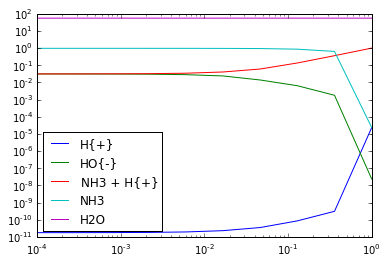

In [20]:
ny = len(rs.substances)
nc = 10
x = np.empty((nc, ny))
Hparr = np.logspace(-4, 0, nc)
success = []
for idx in range(nc):
    x00 = x0[:]
    x00[0] = Hparr[idx]
    resx, res = rs.root(x00, scaling=1e12)
    success.append(res.success)
    x[idx, :] = resx
for idx_s in range(ny):
    plt.loglog(Hparr, x[:, idx_s], label=rs.substances[idx_s].name)
plt.legend(loc='best')
for i, s in enumerate(success):
    if s is False:
        plt.axvline(Hparr[i], c='k', ls='--')

In [21]:
init_conc

{Solute(name=NH3, ...): 1.0,
 Solute(name=H{+}, ...): 1e-07,
 Solute(name=HO{-}, ...): 1e-07,
 Solute(name=H2O, ...): 55.5,
 Solute(name=NH3 + H{+}, ...): 1e-07}

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The number of calls to function has reached maxfev = 500.
  warnings.warn(msg, RuntimeWarning)


('neg_conc, too_much', True, True)
('neg_conc, too_much', True, True)


(False, False, True, False, False, True)

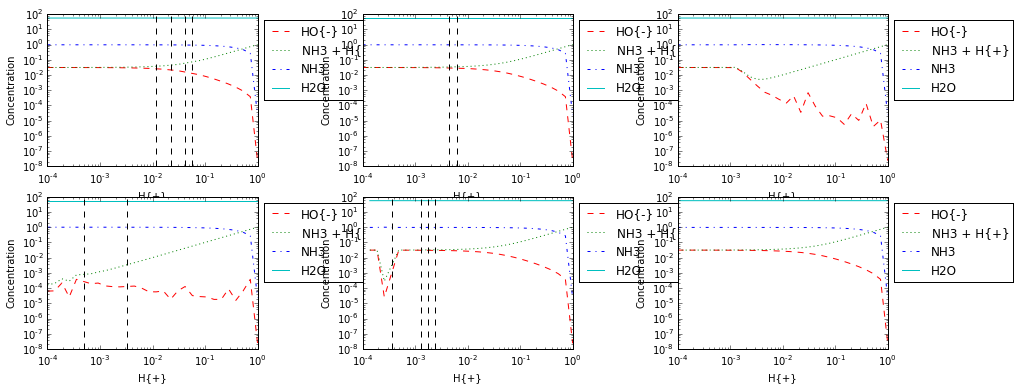

In [22]:
nc=30
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 3, 1, xscale='log', yscale='log')
Cout_1, ic1, success1 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, ax=ax1)
ax2 = plt.subplot(2, 3, 2, xscale='log', yscale='log')
Cout_2, ic2, success2 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, const=(H2O,), ax=ax2)
ax3 = plt.subplot(2, 3, 3, xscale='log', yscale='log')
Cout_3, ic3, success3 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, method='lm', ax=ax3)
ax4 = plt.subplot(2, 3, 4, xscale='log', yscale='log')
Cout_4, ic4, success4 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, reduced=True, ax=ax4)
ax5 = plt.subplot(2, 3, 5, xscale='log', yscale='log')
Cout_5, ic5, success5 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, reduced=True, norm=True, ax=ax5)
ax6 = plt.subplot(2, 3, 6, xscale='log', yscale='log')
Cout_6, ic6, success6 = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, rref=False, ax=ax6, charge=False)
all(success1), all(success2), all(success3), all(success4), all(success5), all(success6)

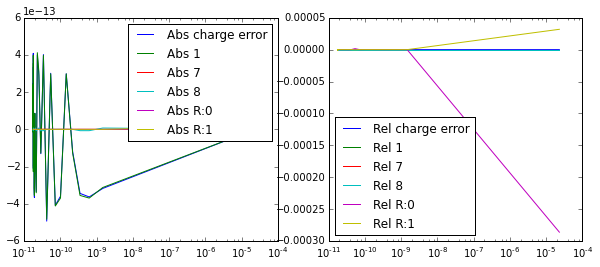

In [23]:
rs.plot_errors(Cout_6, ic6, Hp)

True

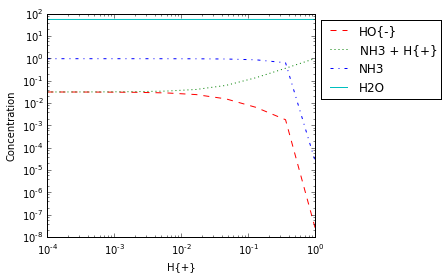

In [100]:
Cout, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, 10), scaling=1e6, reduced=True, norm=True
                            , method='lm',
                           # extra_pres_sq=True
                           )
all(success)

True

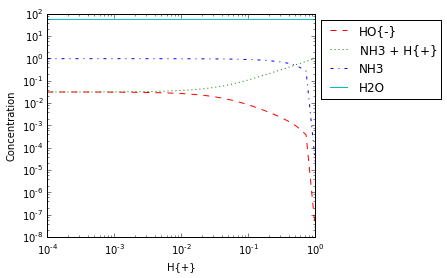

In [25]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, rref=False, charge=False,
                                norm=True, pres_norm=True, presw=1000)
all(success)

True

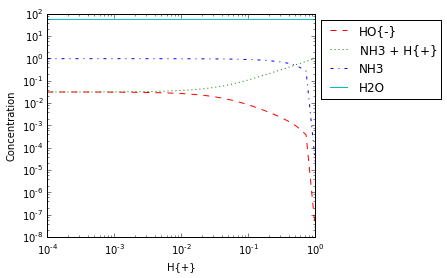

In [26]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, norm=True, method='lm')
all(success)

True

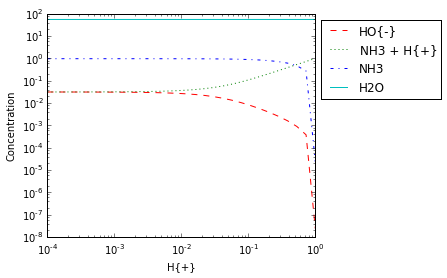

In [27]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, norm=True, init_iter=15)
all(success)

True

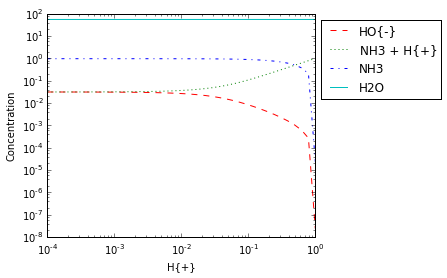

In [96]:
nc = 40
scaling = 1e8
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=scaling,
                               norm=True, init_iter=15, carry=False, pres_norm=True, presw=scaling)
    # pres1st=True, method='lm', <--- Does not matter
    # extra_pres_sq=True <--- Makes things worse
all(success)

True

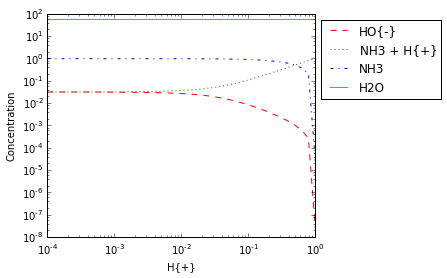

In [29]:
Cout, inits, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e6, pres1st=True, presw=1,
                               norm=True, init_iter=15)
all(success)

{Solute(name=NH3, ...): 1.0,
 Solute(name=H{+}, ...): 1e-07,
 Solute(name=HO{-}, ...): 1e-07,
 Solute(name=H2O, ...): 55.5,
 Solute(name=NH3 + H{+}, ...): 1e-07}

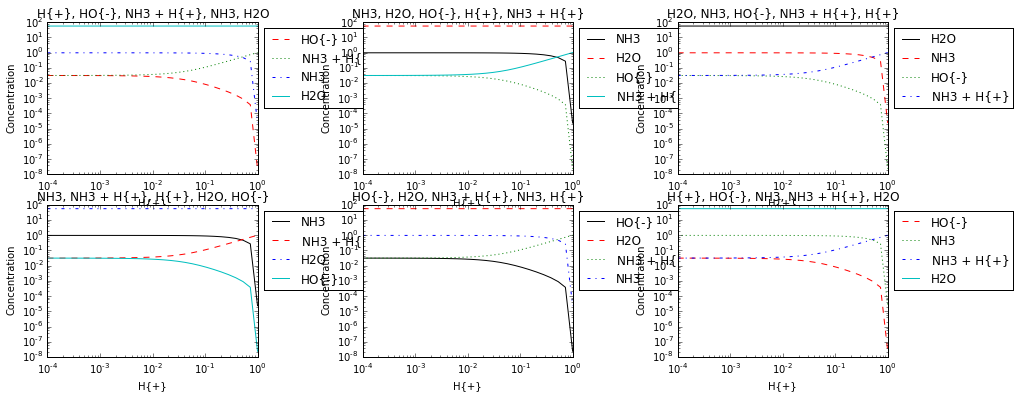

In [30]:
import random
subst = tuple(rs.substances)
plt.figure(figsize=(16,6))
for i in range(1, 2*3+1):
    ax = plt.subplot(2, 3, i, xscale='log', yscale='log')
    Cout, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, 30), ax=ax, scaling=1e12,
                                norm=True, pres_norm=True, presw=1000
                                #charge=False, rref=False
                                #reduced=True
                               )
                                 #norm=True, pres_norm=True, presw=1000)
    plt.title(', '.join([str(s) for s in rs.substances]))
    random.shuffle(rs.substances)
rs.substances = list(subst)
init_conc

In [31]:
init_conc

{Solute(name=NH3, ...): 1.0,
 Solute(name=H{+}, ...): 1e-07,
 Solute(name=HO{-}, ...): 1e-07,
 Solute(name=H2O, ...): 55.5,
 Solute(name=NH3 + H{+}, ...): 1e-07}

True

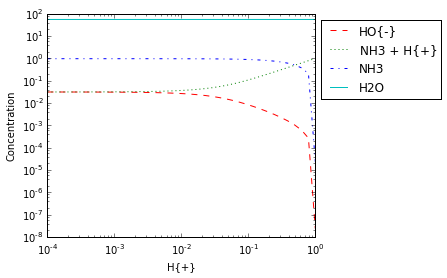

In [32]:
Cout_14, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1, norm=True, pres_norm=True,
                               rref=True, method='lm') #, options=dict(maxfev=300*rs.ns))
all(success)

True

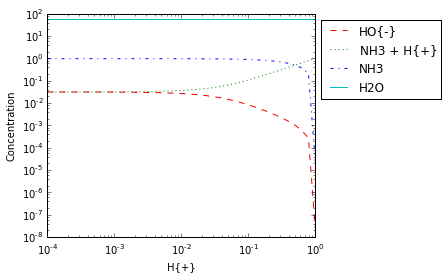

In [33]:
Cout_reduced, ic, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1, norm=True, reduced=True,
                                    method='lm') #, options=dict(maxfev=300*rs.ns))
all(success)

/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/bjorn/.local/lib/python2.7/site-packages/numpy/__i

False

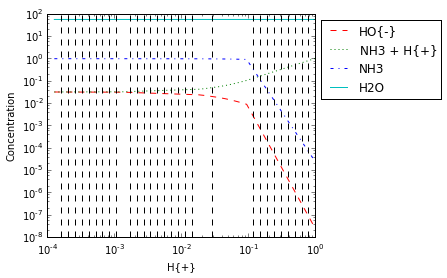

In [34]:
Cout_logC, inits_out, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), logC=True, presw=1e2, scaling=1,
                                        norm=True, pres_norm=True)
all(success)

/home/bjorn/.local/lib/python2.7/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


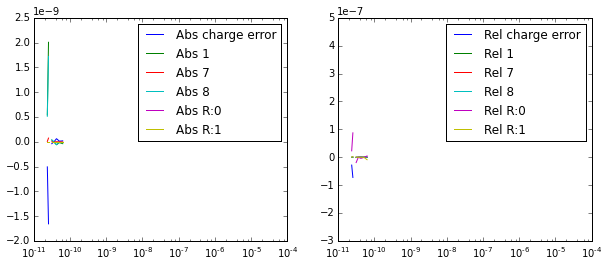

In [35]:
rs.plot_errors(Cout_logC, inits_out, Hp)

True

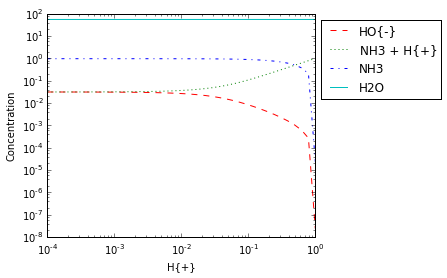

In [36]:
Cout_logC, inits_out, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), logC=True, init_guess=Cout_14, init_iter=0)
all(success)

True

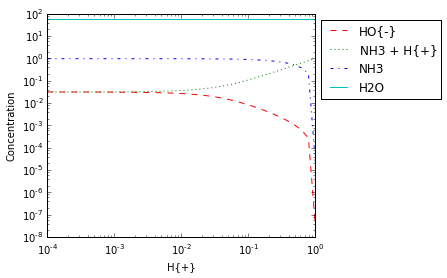

In [37]:
Cout_14, ic14, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e14, carry=True)
all(success)

False

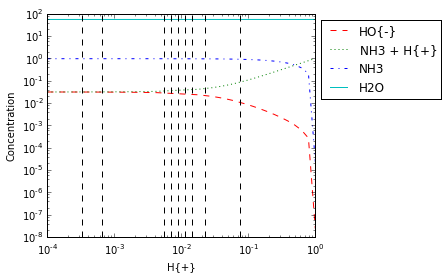

In [38]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-4, tol=1e-12, init_iter=100)
all(success)

True

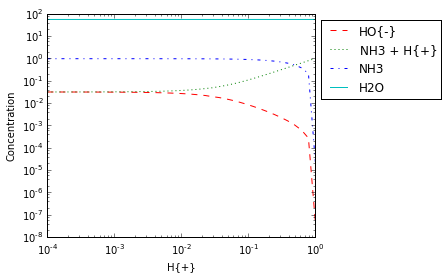

In [39]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-8)
all(success)

True

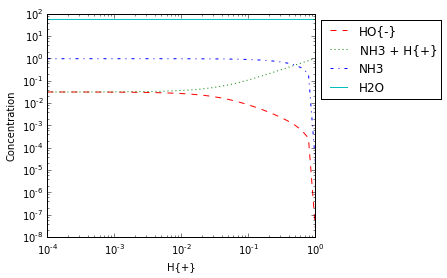

In [40]:
_1, _2, success = rs.plot(init_conc, Hp, np.logspace(-4, 0, nc), scaling=1e-8, carry=True)
all(success)

(True, (40, 5))

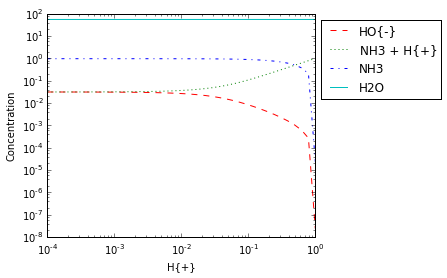

In [41]:
Cout, inits_out, success = rs.plot(Cout_14, Hp, np.logspace(-4, 0, nc), scaling=1, init_iter=0, method='lm')
all(success), Cout.shape

True

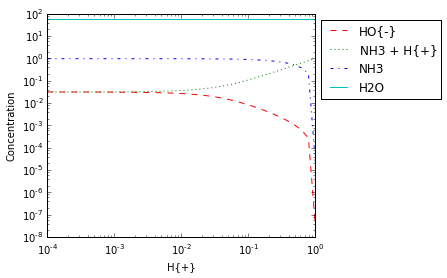

In [42]:
Cout, inits_out, success = rs.plot(Cout_14, Hp, np.logspace(-4, 0, nc), scaling=1, logC=True, init_iter=0, method='lm')
all(success)

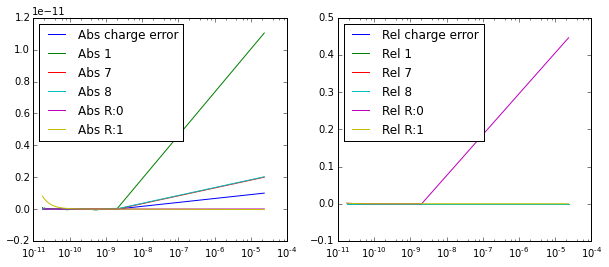

In [43]:
rs.plot_errors(Cout, inits_out, Hp)

In [44]:
x0

In [45]:
from aqchem.equilibria import solve_equilibrium
_x0 = x0[:]
print(_x0)
for w in range(1,5):
    for eq in rs.rxns:
        new_x0 = solve_equilibrium(x0, eq.net_stoich(rs.substances), eq.params)
        _x0 = (w*_x0 + new_x0)/(w+1)
        print(x0)

[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[1e-07, 1e-07, 1e-07, 1.0, 55.5]


In [4]:
#Cout, inits_out, success = reqsys.plot(init_conc, Hp, np.logspace(-7, 0, 20), scaling=1e6, carry=False)